In [490]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split

In [491]:
def wrangle_market_data(file_path, target_type='3class_extreme', threshold=0.00015):
    """
    Convert 1-second market data to minute-level features with target variable.
    
    Parameters:
    -----------
    file_path : str
        Path to CSV file
    target_type : str
        '3class_extreme' for 0=neutral, 1=major up, 2=major down
    threshold : float
        Return threshold for extreme moves (default 0.001 = 0.1%)
    
    Returns:
    --------
    minute_df : DataFrame
        Full minute-level dataframe
    """
    
    # Load and prepare data
    df = (
        pd.read_csv(file_path)
          .drop(columns=["Date"])
          .set_index("Time")
    )
    
    df.index = pd.to_datetime(df.index, format="%H:%M:%S.%f")
    
    # Calculate mid price
    df["MID_PRICE"] = (df["BID_PRICE"] + df["ASK_PRICE"]) / 2
    
    # Calculate changes
    df["mid_change"] = df["MID_PRICE"].diff()
    df["volume_change"] = df["LTQ"].diff()
    
    # Calculate second-level OFI
    df["OFI_second"] = 0
    df.loc[df["mid_change"] > 0, "OFI_second"] = df["volume_change"]
    df.loc[df["mid_change"] < 0, "OFI_second"] = -df["volume_change"]
    
    # Aggregate to minute level
    df['minute'] = df.index.floor('1min')
    
    minute_df = df.groupby('minute').agg({
        'OFI_second': 'sum',
        'volume_change': 'sum',
        'MID_PRICE': ['first', 'last'],
        'BID_PRICE': 'mean',
        'ASK_PRICE': 'mean',
    }).reset_index()
    
    # Flatten column names
    minute_df.columns = ['minute', 'OFI_minute', 'total_volume', 
                         'mid_start', 'mid_end', 'avg_bid', 'avg_ask']
    
    # Calculate features
    minute_df['price_change'] = minute_df['mid_end'] - minute_df['mid_start']
    minute_df['minute_return'] = np.log(minute_df['mid_end'] / minute_df['mid_start'])
    
    # Feature 1: OFI intensity
    minute_df['OFI_intensity'] = minute_df['OFI_minute'] / minute_df['total_volume']
    minute_df['OFI_intensity'] = minute_df['OFI_intensity'].fillna(0)
    
    # Feature 2: Volume ratio
    minute_df['volume_ratio'] = minute_df['total_volume'] / minute_df['total_volume'].rolling(60).mean()
    minute_df['volume_ratio'] = minute_df['volume_ratio'].fillna(1.0)
    
    # Create target
    minute_df['target_return'] = minute_df['minute_return'].shift(-1)
    
    # 3-class extreme: 0=neutral, 1=major up, 2=major down
    minute_df['target'] = np.where(
        minute_df['target_return'] > threshold, 1,      # Major UP
        np.where(
            minute_df['target_return'] < -threshold, 2,  # Major DOWN
            0                                             # Neutral (no trade)
        )
    )
    
    # Drop last row (no target)
    minute_df = minute_df[:-1].copy()
    
    return minute_df

In [492]:
folders = [
    "GFDLNFO_TICK_01102025",
    "GFDLNFO_TICK_03102025",
    "GFDLNFO_TICK_06102025",
    "GFDLNFO_TICK_07102025",
    "GFDLNFO_TICK_08102025",
    "GFDLNFO_TICK_09102025",
    "GFDLNFO_TICK_10102025",
    "GFDLNFO_TICK_13102025",
    "GFDLNFO_TICK_14102025",
    "GFDLNFO_TICK_15102025",
    "GFDLNFO_TICK_16102025",
    "GFDLNFO_TICK_17102025",
    "GFDLNFO_TICK_20102025",
    "GFDLNFO_TICK_23102025",
    "GFDLNFO_TICK_24102025",
    "GFDLNFO_TICK_27102025",
    "GFDLNFO_TICK_28102025",
    "GFDLNFO_TICK_29102025",
    "GFDLNFO_TICK_30102025",
    "GFDLNFO_TICK_31102025"
]


In [493]:
X_list = []
y_list = []
minute_df_list = []

for folder in folders:
    file_path = f"../data/TICK data/OCT_2025/{folder}/Futures/-I/HINDALCO-I.NFO.csv"
    
    try:
        # Process file
        minute_df_temp = wrangle_market_data(file_path, target_type='binary')
        
        # Extract X and y
        X = minute_df_temp[['OFI_minute', 'volume_ratio']]
        y = minute_df_temp['target']
        
        # Add source tracking (optional but useful)
        minute_df_temp['source_file'] = folder
        
        # Append to lists
        X_list.append(X)
        y_list.append(y)
        minute_df_list.append(minute_df_temp)
        
    except FileNotFoundError:
        print(f"✗ File not found: {folder}")
    except Exception as e:
        print(f"✗ Error in {folder}: {str(e)}")

# Concatenate everything
X = pd.concat(X_list, axis=0, ignore_index=True)
y = pd.concat(y_list, axis=0, ignore_index=True)
minute_df = pd.concat(minute_df_list, axis=0, ignore_index=True)

print(f"\n{'='*50}")
print(f"Total minutes: {len(X)}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"Target percentage:\n{y.value_counts(normalize=True)}")
print(f"{'='*50}")


Total minutes: 7500
Target distribution:
target
1    2581
2    2502
0    2417
Name: count, dtype: int64
Target percentage:
target
1    0.344133
2    0.333600
0    0.322267
Name: proportion, dtype: float64


In [494]:
len(X),len(y)

(7500, 7500)

In [495]:
# Step 1: 60% train, 40% remaining
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)

# Step 2: Split 40% into 50/50 → each gets 20% of original
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

In [496]:
model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [497]:
accuracy_score(y_test,model.predict(X_test))

0.37066666666666664

In [498]:
accuracy_score(y_val,model.predict(X_val))

0.37866666666666665

In [499]:
accuracy_score(y_train,model.predict(X_train))

0.382

In [500]:
confusion_matrix(y_train,model.predict(X_train))

array([[884, 462,  88],
       [757, 661, 125],
       [759, 590, 174]])

In [501]:
print(classification_report(y_train,model.predict(X_train)
))

              precision    recall  f1-score   support

           0       0.37      0.62      0.46      1434
           1       0.39      0.43      0.41      1543
           2       0.45      0.11      0.18      1523

    accuracy                           0.38      4500
   macro avg       0.40      0.39      0.35      4500
weighted avg       0.40      0.38      0.35      4500



In [502]:
depth_hyperparams = range(1,50,2)

In [503]:
training_acc =  []
validation_acc = []
for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = DecisionTreeClassifier(random_state=42, max_depth=d)
        
    #Fit model to the training data
    test_model.fit(X_train, y_train)
    #Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train,y_train))
    #Calculate validation accuracy score and append to `validation_acc`
    validation_acc.append(test_model.score(X_val,y_val))

    print("Training Accuracy Scores:", training_acc[:3])
    print("Validation Accuracy Scores:", validation_acc[:3])


Training Accuracy Scores: [0.3662222222222222]
Validation Accuracy Scores: [0.386]
Training Accuracy Scores: [0.3662222222222222, 0.382]
Validation Accuracy Scores: [0.386, 0.37866666666666665]
Training Accuracy Scores: [0.3662222222222222, 0.382, 0.404]
Validation Accuracy Scores: [0.386, 0.37866666666666665, 0.36866666666666664]
Training Accuracy Scores: [0.3662222222222222, 0.382, 0.404]
Validation Accuracy Scores: [0.386, 0.37866666666666665, 0.36866666666666664]
Training Accuracy Scores: [0.3662222222222222, 0.382, 0.404]
Validation Accuracy Scores: [0.386, 0.37866666666666665, 0.36866666666666664]
Training Accuracy Scores: [0.3662222222222222, 0.382, 0.404]
Validation Accuracy Scores: [0.386, 0.37866666666666665, 0.36866666666666664]
Training Accuracy Scores: [0.3662222222222222, 0.382, 0.404]
Validation Accuracy Scores: [0.386, 0.37866666666666665, 0.36866666666666664]
Training Accuracy Scores: [0.3662222222222222, 0.382, 0.404]
Validation Accuracy Scores: [0.386, 0.378666666666

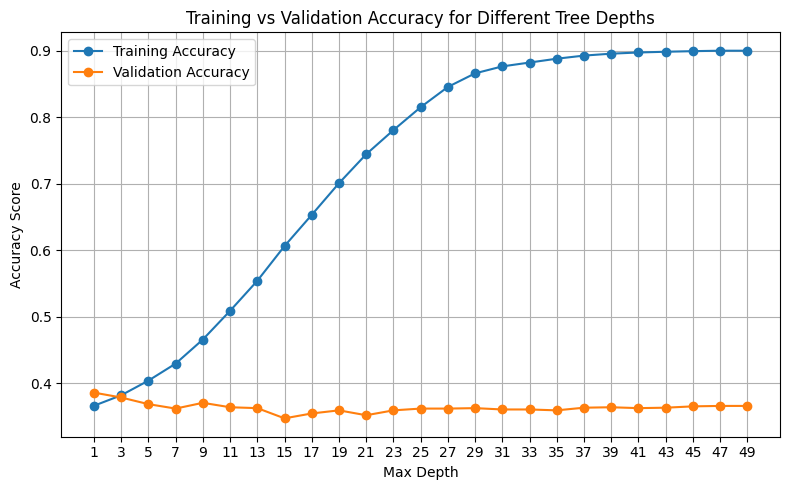

In [504]:
plt.figure(figsize=(8,5))

plt.plot(depth_hyperparams, training_acc, marker='o', label="Training Accuracy")
plt.plot(depth_hyperparams, validation_acc, marker='o', label="Validation Accuracy")


plt.xticks(depth_hyperparams)

plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.title("Training vs Validation Accuracy for Different Tree Depths")

plt.grid(True)  # Add grid
plt.legend()
plt.tight_layout()
plt.show()


In [505]:
equity_df = pd.DataFrame()
equity_df["y_true"] = y
equity_df["y_pred"] = model.predict(X)
equity_df["log_returns"] = minute_df["target_return"]

In [506]:
equity_df

,y_true,y_pred,log_returns
0,2,1,-0.000653
1,1,1,0.000621
2,2,1,-0.000457
3,2,1,-0.001340
4,2,1,-0.000393
...,...,...,...
7495,0,1,-0.000029
7496,0,0,-0.000088
7497,0,0,0.000088
7498,1,2,0.000410


In [507]:
# Step 1: Shift log_returns to get next period's return (exit at next timestamp)
equity_df['next_return'] = equity_df['log_returns'].shift(-1)

# Step 2: Calculate position direction
# Buy = 1, Sell = -1, No position = 0
equity_df['position'] = equity_df['y_pred'].map({1: 1, 2: -1, 0: 0})

# Step 3: Calculate dollar P&L for each trade
equity_df['pnl'] = equity_df['position'] * equity_df['next_return'] * 100

# Step 4: Calculate cumulative P&L
equity_df['cumulative_pnl'] = equity_df['pnl'].fillna(0).cumsum()

# Step 5: Calculate equity curve (starting capital = $100)
equity_df['equity'] = 100 + equity_df['cumulative_pnl']

# View results
print(equity_df[['y_pred', 'log_returns', 'next_return', 'position', 'pnl', 'cumulative_pnl', 'equity']].head(10))

# Summary statistics
print(f"\nTotal P&L: ${equity_df['pnl'].sum():.2f}")
print(f"Number of trades: {(equity_df['position'] != 0).sum()}")
print(f"Win rate: {(equity_df['pnl'] > 0).sum() / (equity_df['position'] != 0).sum() * 100:.2f}%")
print(f"Final equity: ${equity_df['equity'].iloc[-1]:.2f}")

   y_pred  log_returns  next_return  position       pnl  cumulative_pnl  \
0       1    -0.000653     0.000621         1  0.062060        0.062060   
1       1     0.000621    -0.000457         1 -0.045725        0.016335   
2       1    -0.000457    -0.001340         1 -0.134029       -0.117693   
3       1    -0.001340    -0.000393         1 -0.039262       -0.156955   
4       1    -0.000393     0.000033         1  0.003272       -0.153683   
5       1     0.000033    -0.001670         1 -0.167019       -0.320702   
6       1    -0.001670    -0.000164         1 -0.016389       -0.337091   
7       1    -0.000164     0.001507         1  0.150681       -0.186410   
8       1     0.001507     0.001047         1  0.104681       -0.081728   
9       1     0.001047     0.000229         1  0.022896       -0.058833   

       equity  
0  100.062060  
1  100.016335  
2   99.882307  
3   99.843045  
4   99.846317  
5   99.679298  
6   99.662909  
7   99.813590  
8   99.918272  
9   99.941167 

In [508]:
import numpy as np

# Step 1: Indian market timing
minutes_per_day = 375  # 9:15 AM to 3:30 PM = 6 hours 15 minutes = 375 minutes
trading_days_per_year = 250  # NSE/BSE average (excluding holidays)
minutes_per_year = minutes_per_day * trading_days_per_year  # 93,750 minutes

# Step 2: Calculate returns per trade (percentage)
equity_df['return_pct'] = equity_df['pnl'] / 100  # Return as fraction

# Step 3: Calculate Sharpe Ratio
mean_return = equity_df['return_pct'].mean()
std_return = equity_df['return_pct'].std()

# Annualized metrics
annualized_return = mean_return * minutes_per_year
annualized_volatility = std_return * np.sqrt(minutes_per_year)

# Sharpe ratio (risk-free rate ≈ 6-7% in India, using 0 for conservative estimate)
sharpe_ratio = annualized_return / annualized_volatility

print(f"\n=== Performance Metrics (Indian Markets) ===")
print(f"Mean return per trade: {mean_return*100:.4f}%")
print(f"Std dev per trade: {std_return*100:.4f}%")
print(f"Annualized return: {annualized_return*100:.2f}%")
print(f"Annualized volatility: {annualized_volatility*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.3f}")

# Additional metrics
print(f"\n=== Trade Statistics ===")
print(f"Total trades: {(equity_df['position'] != 0).sum()}")
print(f"Total P&L: ₹{equity_df['pnl'].sum():.2f}")
print(f"Win rate: {(equity_df['pnl'] > 0).sum() / (equity_df['position'] != 0).sum() * 100:.2f}%")
print(f"Avg win: ₹{equity_df[equity_df['pnl'] > 0]['pnl'].mean():.4f}")
print(f"Avg loss: ₹{equity_df[equity_df['pnl'] < 0]['pnl'].mean():.4f}")

# For adjusted Sharpe with Indian risk-free rate (~6.5%)
risk_free_rate = 0.065
sharpe_adjusted = (annualized_return - risk_free_rate) / annualized_volatility
print(f"Sharpe Ratio (adjusted for Rf=6.5%): {sharpe_adjusted:.3f}")


=== Performance Metrics (Indian Markets) ===
Mean return per trade: 0.0011%
Std dev per trade: 0.0477%
Annualized return: 102.36%
Annualized volatility: 14.61%
Sharpe Ratio: 7.008

=== Trade Statistics ===
Total trades: 3494
Total P&L: ₹8.19
Win rate: 50.52%
Avg win: ₹0.0496
Avg loss: ₹-0.0492
Sharpe Ratio (adjusted for Rf=6.5%): 6.563


In [509]:
import numpy as np

# Step 1: Indian market timing
minutes_per_day = 375  # 9:15 AM to 3:30 PM
trading_days_per_month = 20  # Given in your data
minutes_per_month = minutes_per_day * trading_days_per_month  # 7,500 minutes

# Step 2: Calculate returns per trade (percentage)
equity_df['return_pct'] = equity_df['pnl'] / 100  # Return as fraction

# Step 3: Calculate Monthly Sharpe Ratio
mean_return = equity_df['return_pct'].mean()
std_return = equity_df['return_pct'].std()

# Monthly metrics (scale to 1 month)
monthly_return = mean_return * minutes_per_month
monthly_volatility = std_return * np.sqrt(minutes_per_month)

# Monthly Sharpe ratio
monthly_sharpe = monthly_return / monthly_volatility

print(f"\n=== Monthly Performance Metrics ===")
print(f"Mean return per trade: {mean_return*100:.4f}%")
print(f"Std dev per trade: {std_return*100:.4f}%")
print(f"Monthly return: {monthly_return*100:.2f}%")
print(f"Monthly volatility: {monthly_volatility*100:.2f}%")
print(f"Monthly Sharpe Ratio: {monthly_sharpe:.3f}")

# Convert to annualized for comparison
annualized_sharpe = monthly_sharpe * np.sqrt(12)
print(f"Annualized Sharpe (from monthly): {annualized_sharpe:.3f}")

print(f"\n=== Trade Statistics ===")
print(f"Total trades in month: {(equity_df['position'] != 0).sum()}")
print(f"Total monthly P&L: ₹{equity_df['pnl'].sum():.2f}")
print(f"Monthly return %: {(equity_df['pnl'].sum() / 100) * 100:.2f}%")


=== Monthly Performance Metrics ===
Mean return per trade: 0.0011%
Std dev per trade: 0.0477%
Monthly return: 8.19%
Monthly volatility: 4.13%
Monthly Sharpe Ratio: 1.982
Annualized Sharpe (from monthly): 6.866

=== Trade Statistics ===
Total trades in month: 3494
Total monthly P&L: ₹8.19
Monthly return %: 8.19%


In [ ]:
# Transaction cost calculation (CORRECTED)
transaction_cost_pct = 0.054 / 100  # 0.054% of turnover for FULL round-trip

# For each trade, turnover = position_size (since we're calculating on notional)
# The 0.054% already includes both legs
equity_df['transaction_cost'] = abs(equity_df['position']) * 100 * transaction_cost_pct

# Net P&L after costs
equity_df['pnl_net'] = equity_df['pnl'] - equity_df['transaction_cost']

# Recalculate all metrics
equity_df['cumulative_pnl_net'] = equity_df['pnl_net'].fillna(0).cumsum()
equity_df['equity_net'] = 100 + equity_df['cumulative_pnl_net']

# Net performance metrics
return_pct_net = equity_df['pnl_net'] / 100
mean_return_net = return_pct_net.mean()
std_return_net = return_pct_net.std()

annualized_return_net = mean_return_net * 93750
annualized_volatility_net = std_return_net * np.sqrt(93750)
sharpe_net = annualized_return_net / annualized_volatility_net
sharpe_adjusted_net = (annualized_return_net - 0.065) / annualized_volatility_net

print(f"\n=== POST-TRANSACTION COST ANALYSIS (CORRECTED) ===")
print(f"Transaction cost per trade: ₹{equity_df['transaction_cost'].mean():.4f}")
print(f"Total transaction costs: ₹{equity_df['transaction_cost'].sum():.2f}")
print(f"\n=== Net Performance Metrics ===")
print(f"Mean return per trade: {mean_return_net*100:.4f}%")
print(f"Std dev per trade: {std_return_net*100:.4f}%")
print(f"Annualized return (net): {annualized_return_net*100:.2f}%")
print(f"Annualized volatility (net): {annualized_volatility_net*100:.2f}%")
print(f"Sharpe Ratio (net): {sharpe_net:.3f}")
print(f"Sharpe Ratio (net, Rf=6.5%): {sharpe_adjusted_net:.3f}")

print(f"\n=== Trade Statistics (Net) ===")
print(f"Gross P&L: ₹{equity_df['pnl'].sum():.2f}")
print(f"Total costs: ₹{equity_df['transaction_cost'].sum():.2f}")
print(f"Net P&L: ₹{equity_df['pnl_net'].sum():.2f}")
print(f"Cost as % of gross profit: {(equity_df['transaction_cost'].sum() / abs(equity_df['pnl'].sum()) * 100):.1f}%")
print(f"Win rate (net): {(equity_df['pnl_net'] > 0).sum() / (equity_df['position'] != 0).sum() * 100:.2f}%")
print(f"Avg win (net): ₹{equity_df[equity_df['pnl_net'] > 0]['pnl_net'].mean():.4f}")
print(f"Avg loss (net): ₹{equity_df[equity_df['pnl_net'] < 0]['pnl_net'].mean():.4f}")

print(f"\n=== Return Analysis ===")


print(f"Monthly return (net): {(equity_df['pnl_net'].sum() / 100) * 100:.2f}%")
print(f"Final equity: ₹{equity_df['equity_net'].iloc[-1]:.2f}")


=== POST-TRANSACTION COST ANALYSIS (CORRECTED) ===
Transaction cost per trade: ₹0.0252
Total transaction costs: ₹188.68

=== Net Performance Metrics ===
Mean return per trade: -0.0241%
Std dev per trade: 0.0542%
Annualized return (net): -2256.40%
Annualized volatility (net): 16.60%
Sharpe Ratio (net): -135.943
Sharpe Ratio (net, Rf=6.5%): -136.335

=== Trade Statistics (Net) ===
Gross P&L: ₹8.19
Total costs: ₹188.68
Net P&L: ₹-180.49
Cost as % of gross profit: 2304.3%
Win rate (net): 16.94%
Avg win (net): ₹0.0496
Avg loss (net): ₹-0.0723

=== Return Analysis ===
Monthly return (net): -180.49%
Final equity: ₹-80.49
